In [ ]:
# Swin Transformer V2 implementation reused from
# https://github.com/leondgarse/keras_cv_attention_models/blob/main/keras_cv_attention_models/resnet_family/resnet_deep.py
# - data preprocessing and brief EDA inspired by https://www.kaggle.com/code/tiletisaitejareddy/malware-classification-ism

In [1]:
# Dependencies
import sys
import os
from math import log
import numpy as np
import pandas as pd
import scipy as sp
from PIL import Image
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping

2025-04-19 16:18:09.020362: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-19 16:18:09.081909: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-19 16:18:10.108966: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data Preprocessing and Basic EDA

In [2]:
# prepare the data

train_root_path = "./malimg_dataset/train"
val_root_path = "./malimg_dataset/validation"

from tensorflow.keras.preprocessing.image import ImageDataGenerator
batches = ImageDataGenerator().flow_from_directory(directory=train_root_path, target_size=(64,64), batch_size=10000)

Found 6527 images belonging to 25 classes.


In [3]:
batches.class_indices

{'Adialer.C': 0,
 'Agent.FYI': 1,
 'Allaple.A': 2,
 'Allaple.L': 3,
 'Alueron.gen!J': 4,
 'Autorun.K': 5,
 'C2LOP.P': 6,
 'C2LOP.gen!g': 7,
 'Dialplatform.B': 8,
 'Dontovo.A': 9,
 'Fakerean': 10,
 'Instantaccess': 11,
 'Lolyda.AA1': 12,
 'Lolyda.AA2': 13,
 'Lolyda.AA3': 14,
 'Lolyda.AT': 15,
 'Malex.gen!J': 16,
 'Obfuscator.AD': 17,
 'Rbot!gen': 18,
 'Skintrim.N': 19,
 'Swizzor.gen!E': 20,
 'Swizzor.gen!I': 21,
 'VB.AT': 22,
 'Wintrim.BX': 23,
 'Yuner.A': 24}

In [4]:
imgs, labels = next(batches)
imgs.shape

(6527, 64, 64, 3)

In [5]:
labels.shape

(6527, 25)

In [6]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(20,30), rows=10, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = 10 # len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(0,50):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(list(batches.class_indices.keys())[np.argmax(titles[i])], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

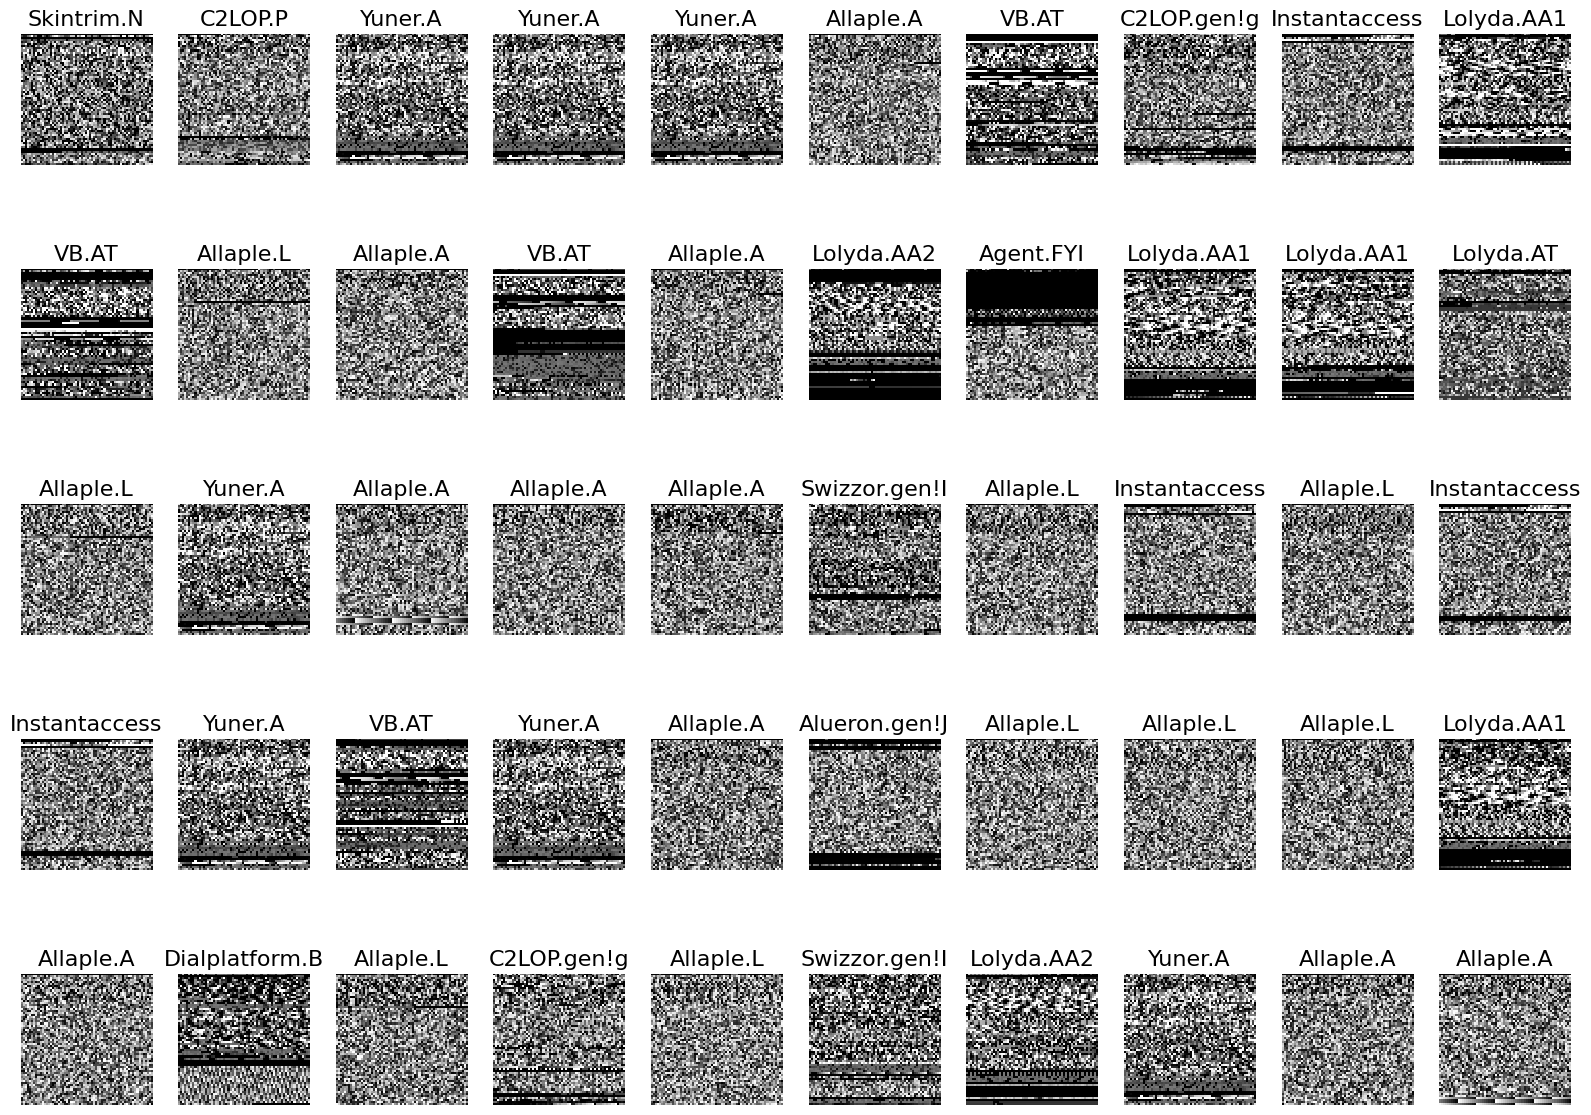

In [7]:
plots(imgs, titles = labels)

<BarContainer object of 25 artists>

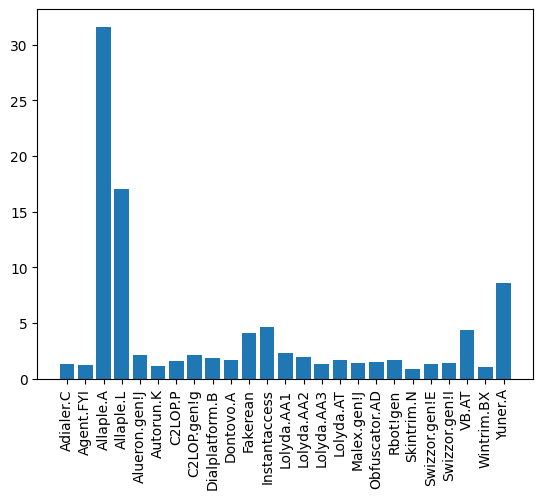

In [8]:
classes = batches.class_indices.keys()
perc = (sum(labels)/labels.shape[0])*100

plt.xticks(rotation='vertical')
plt.bar(classes,perc)

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(imgs/255.,labels, test_size=0.3)

In [10]:
x_train.shape

(4568, 64, 64, 3)

In [11]:
y_test.shape

(1959, 25)

In [12]:
num_classes = len(classes)
# we do not need to apply one-hot encoding to the labels as in https://keras.io/examples/vision/swin_transformers/
# since the dataset data is already prepared for the multi-class classification
#y_train = keras.utils.to_categorical(y_train, num_classes)
#y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (4568, 64, 64, 3) - y_train shape: (4568, 25)
x_test shape: (1959, 64, 64, 3) - y_test shape: (1959, 25)


# ResNet Model

In [14]:
from tensorflow.keras.applications import (
    ResNet50, ResNet101,
    DenseNet121, DenseNet169, DenseNet201
)
from tensorflow.keras.applications.resnet import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.densenet import preprocess_input as densenet_preprocess

def get_model(model_name, input_shape=(64, 64, 3), num_classes=25, pretrained=False):
    weights = 'imagenet' if pretrained else None

    if model_name == 'resnet50':
        base_model = ResNet50(input_shape=input_shape, weights=weights, include_top=False)
        preprocess = resnet_preprocess
    elif model_name == 'resnet101':
        base_model = ResNet101(input_shape=input_shape, weights=weights, include_top=False)
        preprocess = resnet_preprocess
    elif model_name == 'densenet121':
        base_model = DenseNet121(input_shape=input_shape, weights=weights, include_top=False)
        preprocess = densenet_preprocess
    elif model_name == 'densenet169':
        base_model = DenseNet169(input_shape=input_shape, weights=weights, include_top=False)
        preprocess = densenet_preprocess
    elif model_name == 'densenet201':
        base_model = DenseNet201(input_shape=input_shape, weights=weights, include_top=False)
        preprocess = densenet_preprocess
    else:
        raise ValueError(f"Model '{model_name}' is not supported.")

    from tensorflow.keras import layers, models

    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model, preprocess

In [15]:
model, preprocess_input = get_model(
    model_name='resnet50',
    input_shape=(64, 64, 3),
    num_classes=25,
    pretrained=False  # or True if testing practical benefit
)

model.summary()

2025-04-19 16:22:23.900678: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-19 16:22:23.992264: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 25)                51225     
                                                                 
Total params: 23638937 (90.18 MB)
Trainable params: 23585817 (89.97 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_data_generators(train_dir, val_dir, test_dir, preprocess_input, target_size=(64, 64), batch_size=128):
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_gen = datagen.flow_from_directory(
        train_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_gen = datagen.flow_from_directory(
        val_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_gen = datagen.flow_from_directory(
        test_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Important for confusion matrix
    )

    return train_gen, val_gen, test_gen

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

def train_model(model, train_gen, val_gen, model_name, epochs=40):
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True),
        ReduceLROnPlateau(patience=3, factor=0.5),
        ModelCheckpoint(f'models/{model_name}.h5', save_best_only=True)
    ]

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks
    )

    return history

In [29]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, test_gen, class_names):
    y_pred = model.predict(test_gen)
    y_pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    print(classification_report(y_true, y_pred_labels, target_names=class_names))

    cm = confusion_matrix(y_true, y_pred_labels)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

Found 6527 images belonging to 25 classes.
Found 1401 images belonging to 25 classes.
Found 1411 images belonging to 25 classes.
Epoch 1/40
51/51 [==============================] - 69s 990ms/step - loss: 1.5449 - accuracy: 0.5773 - val_loss: 50.1513 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/40
51/51 [==============================] - 49s 954ms/step - loss: 0.5651 - accuracy: 0.8506 - val_loss: 3.8849 - val_accuracy: 0.3155 - lr: 0.0010
Epoch 3/40
51/51 [==============================] - 48s 926ms/step - loss: 0.2483 - accuracy: 0.9501 - val_loss: 3.9353 - val_accuracy: 0.3276 - lr: 0.0010
Epoch 4/40
51/51 [==============================] - 48s 937ms/step - loss: 0.1384 - accuracy: 0.9720 - val_loss: 1.7415 - val_accuracy: 0.5218 - lr: 0.0010
Epoch 5/40
51/51 [==============================] - 49s 955ms/step - loss: 0.1605 - accuracy: 0.9740 - val_loss: 1.5862 - val_accuracy: 0.5596 - lr: 0.0010
Epoch 6/40
51/51 [==============================] - 49s 950ms/step - loss: 0.0664 - ac

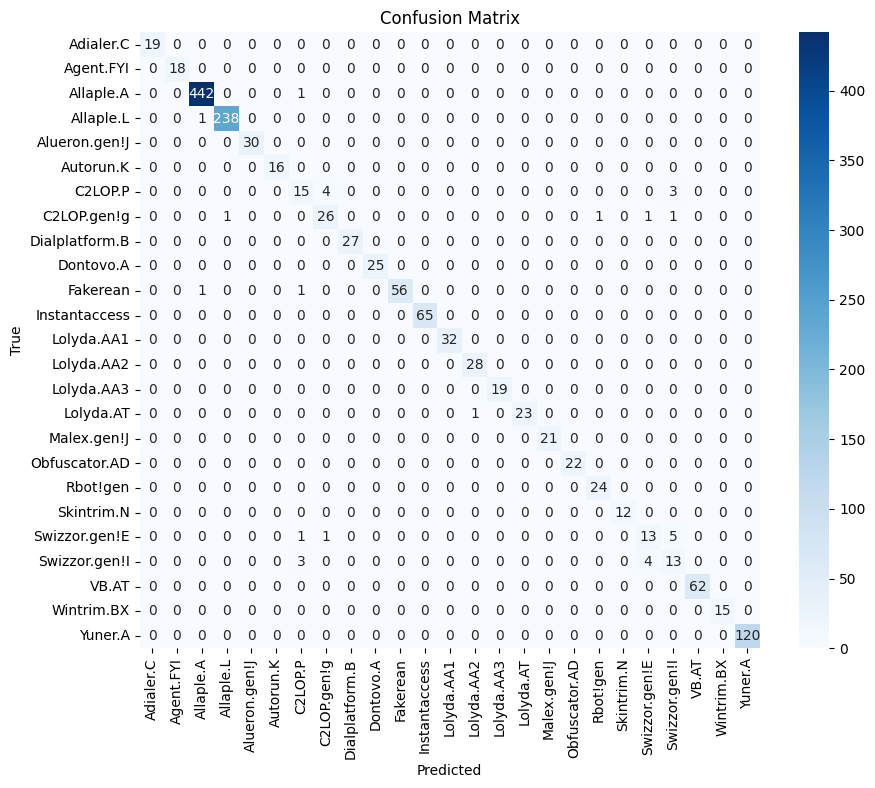

In [30]:
model_name = 'resnet50'
model, preprocess = get_model(model_name, pretrained=False)
train_gen, val_gen, test_gen = get_data_generators(
    'malimg_dataset/train', 'malimg_dataset/val', 'malimg_dataset/test',
    preprocess_input=preprocess
)
history = train_model(model, train_gen, val_gen, model_name=model_name)
evaluate_model(model, test_gen, class_names=list(train_gen.class_indices.keys()))

Found 6527 images belonging to 25 classes.
Found 1401 images belonging to 25 classes.
Found 1411 images belonging to 25 classes.
Epoch 1/40
51/51 [==============================] - ETA: 0s - loss: 1.9987 - accuracy: 0.5154

/research2/ajpecoraro/research-venv/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


51/51 [==============================] - 124s 2s/step - loss: 1.9987 - accuracy: 0.5154 - val_loss: 2.3743 - val_accuracy: 0.2184 - lr: 0.0010
Epoch 2/40
51/51 [==============================] - 85s 2s/step - loss: 0.9132 - accuracy: 0.7472 - val_loss: 6.0399 - val_accuracy: 0.1706 - lr: 0.0010
Epoch 3/40
51/51 [==============================] - 81s 2s/step - loss: 0.3120 - accuracy: 0.9124 - val_loss: 7.2644 - val_accuracy: 0.1706 - lr: 0.0010
Epoch 4/40
51/51 [==============================] - 84s 2s/step - loss: 0.1835 - accuracy: 0.9576 - val_loss: 5.2525 - val_accuracy: 0.1856 - lr: 0.0010
Epoch 5/40
51/51 [==============================] - 80s 2s/step - loss: 0.1176 - accuracy: 0.9786 - val_loss: 4.9247 - val_accuracy: 0.3076 - lr: 5.0000e-04
Epoch 6/40
51/51 [==============================] - 81s 2s/step - loss: 0.0922 - accuracy: 0.9833 - val_loss: 2.1947 - val_accuracy: 0.5196 - lr: 5.0000e-04
Epoch 7/40
51/51 [==============================] - 83s 2s/step - loss: 0.0149 - acc

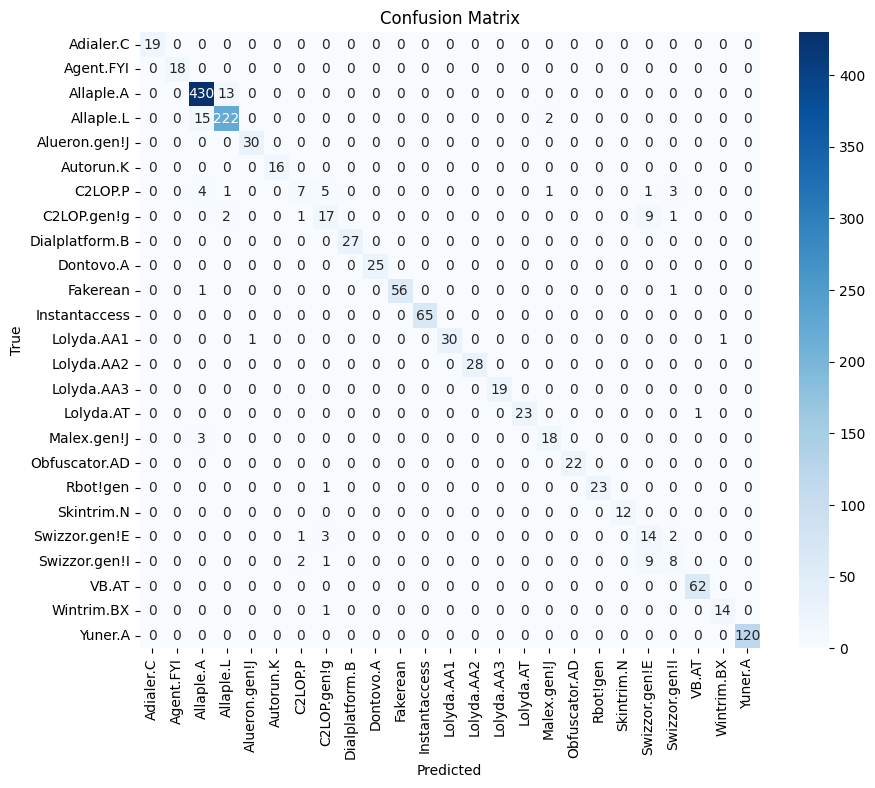

In [31]:
model_name = 'resnet101'
model, preprocess = get_model(model_name, pretrained=False)
train_gen, val_gen, test_gen = get_data_generators(
    'malimg_dataset/train', 'malimg_dataset/val', 'malimg_dataset/test',
    preprocess_input=preprocess
)
history = train_model(model, train_gen, val_gen, model_name=model_name)
evaluate_model(model, test_gen, class_names=list(train_gen.class_indices.keys()))